In [1]:
import pandas as pd

import seaborn as sns

from helpers.modeling_helpers import load_model

from helpers.visualisation_helpers import feature_importance_plot,feature_importance_subplots
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import classification_report

from sklearn.inspection import permutation_importance



In [2]:
df_test = pd.read_csv("data/split/test_data.csv",sep=";",index_col=0)
X_test = df_test.drop(columns=['y'])
y_test = df_test["y"]

df_valid = pd.read_csv("data/split/valid_data.csv",sep=";",index_col=0)
X_valid = df_valid.drop(columns=['y'])
y_valid = df_valid["y"]

In [3]:
path_list = Path("models").rglob('*.pkl')
trained_models_str=[]
trained_models=[]
for path in path_list:
    trained_models_str.append(str(path).split("\\")[1].split(".")[0])
    model = load_model(str(path))
    trained_models.append(model)
    

In [4]:
trained_models_str

['decision_tree_model',
 'knn_model',
 'logistic_regression_model',
 'naive_bayes_model',
 'random_forest_model',
 'svc_model']

In [5]:
trained_models

[DecisionTreeClassifier(criterion='log_loss', max_depth=60),
 KNeighborsClassifier(n_neighbors=1),
 LogisticRegression(C=10),
 GaussianNB(),
 RandomForestClassifier(criterion='entropy', max_depth=40),
 SVC(C=10)]

# MODEL EVALUATION

In [6]:
df_report= pd.DataFrame(columns=["model","accuracy","f1_yes","f1_no"] )

for model_id,model in zip(trained_models_str,trained_models):
    y_pred = model.predict(X_valid)
    report = classification_report(y_valid,y_pred,output_dict=True)
    acc = report['accuracy']
    f1_yes = report['yes']['f1-score']
    f1_no = report['no']['f1-score']
    df_report.loc[model_id]=[model_id,acc,f1_yes,f1_no]
 
df_time = pd.read_csv("results/train_time.csv",sep=";",index_col=False)
df_time.columns=["model","time"]
df_time.set_index("model",inplace=True)
df_time
 
    
df_report.set_index("model",inplace=True)  
df_report = pd.merge(df_report,df_time,left_index=True,right_index=True)
df_report

,accuracy,f1_yes,f1_no,time
model,,,,
decision_tree_model,0.916483,0.918754,0.914080,0.439408
knn_model,0.938558,0.943139,0.933173,0.048405
naive_bayes_model,0.667035,0.560039,0.732169,0.066183
random_forest_model,0.958609,0.959814,0.957330,5.380722
svc_model,0.934327,0.936261,0.932271,119.411662


C:\Users\alekw\AppData\Local\Temp\ipykernel_70572\2272861960.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['{:.0%}'.format(x) for x in axes[i].get_xticks()])
C:\Users\alekw\AppData\Local\Temp\ipykernel_70572\2272861960.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['{:.0%}'.format(x) for x in axes[i].get_xticks()])
C:\Users\alekw\AppData\Local\Temp\ipykernel_70572\2272861960.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['{:.0%}'.format(x) for x in axes[i].get_xticks()])
C:\Users\alekw\AppData\Local\Temp\ipykernel_70572\2272861960.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a

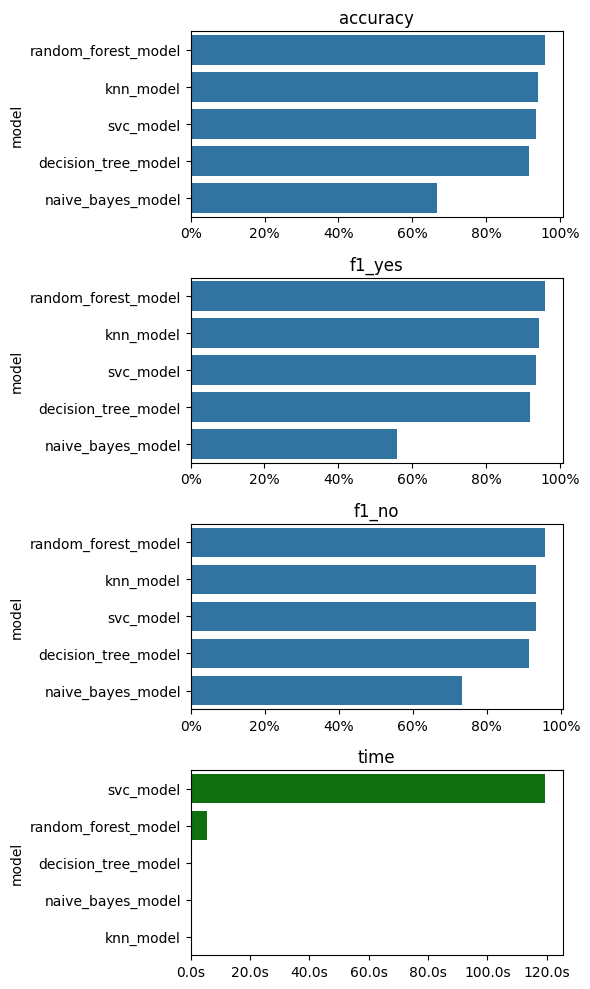

In [7]:

fig, axes = plt.subplots(4,figsize=(6,10),sharey=False,)

for i,metric in enumerate(df_report):
   if metric != "time":
      sns.barplot(data=df_report.reset_index().sort_values(metric,ascending=False),
                  y="model",x=metric,ax=axes[i])

      axes[i].set_title(metric)
      axes[i].set_xticklabels(['{:.0%}'.format(x) for x in axes[i].get_xticks()])
      axes[i].set_xlabel(None)
   else:
      axes[i].set_title(metric)
      sns.barplot(data=df_report.reset_index().sort_values(metric,ascending=False),y="model",x=metric,ax=axes[i],color="green")
      axes[i].set_xticklabels([f"{x}s" for x in axes[i].get_xticks()])
      axes[i].set_xlabel(None)
   
 
plt.tight_layout()
fig.savefig("results/model_metrics.png")

## FEATURE IMPORTANCE

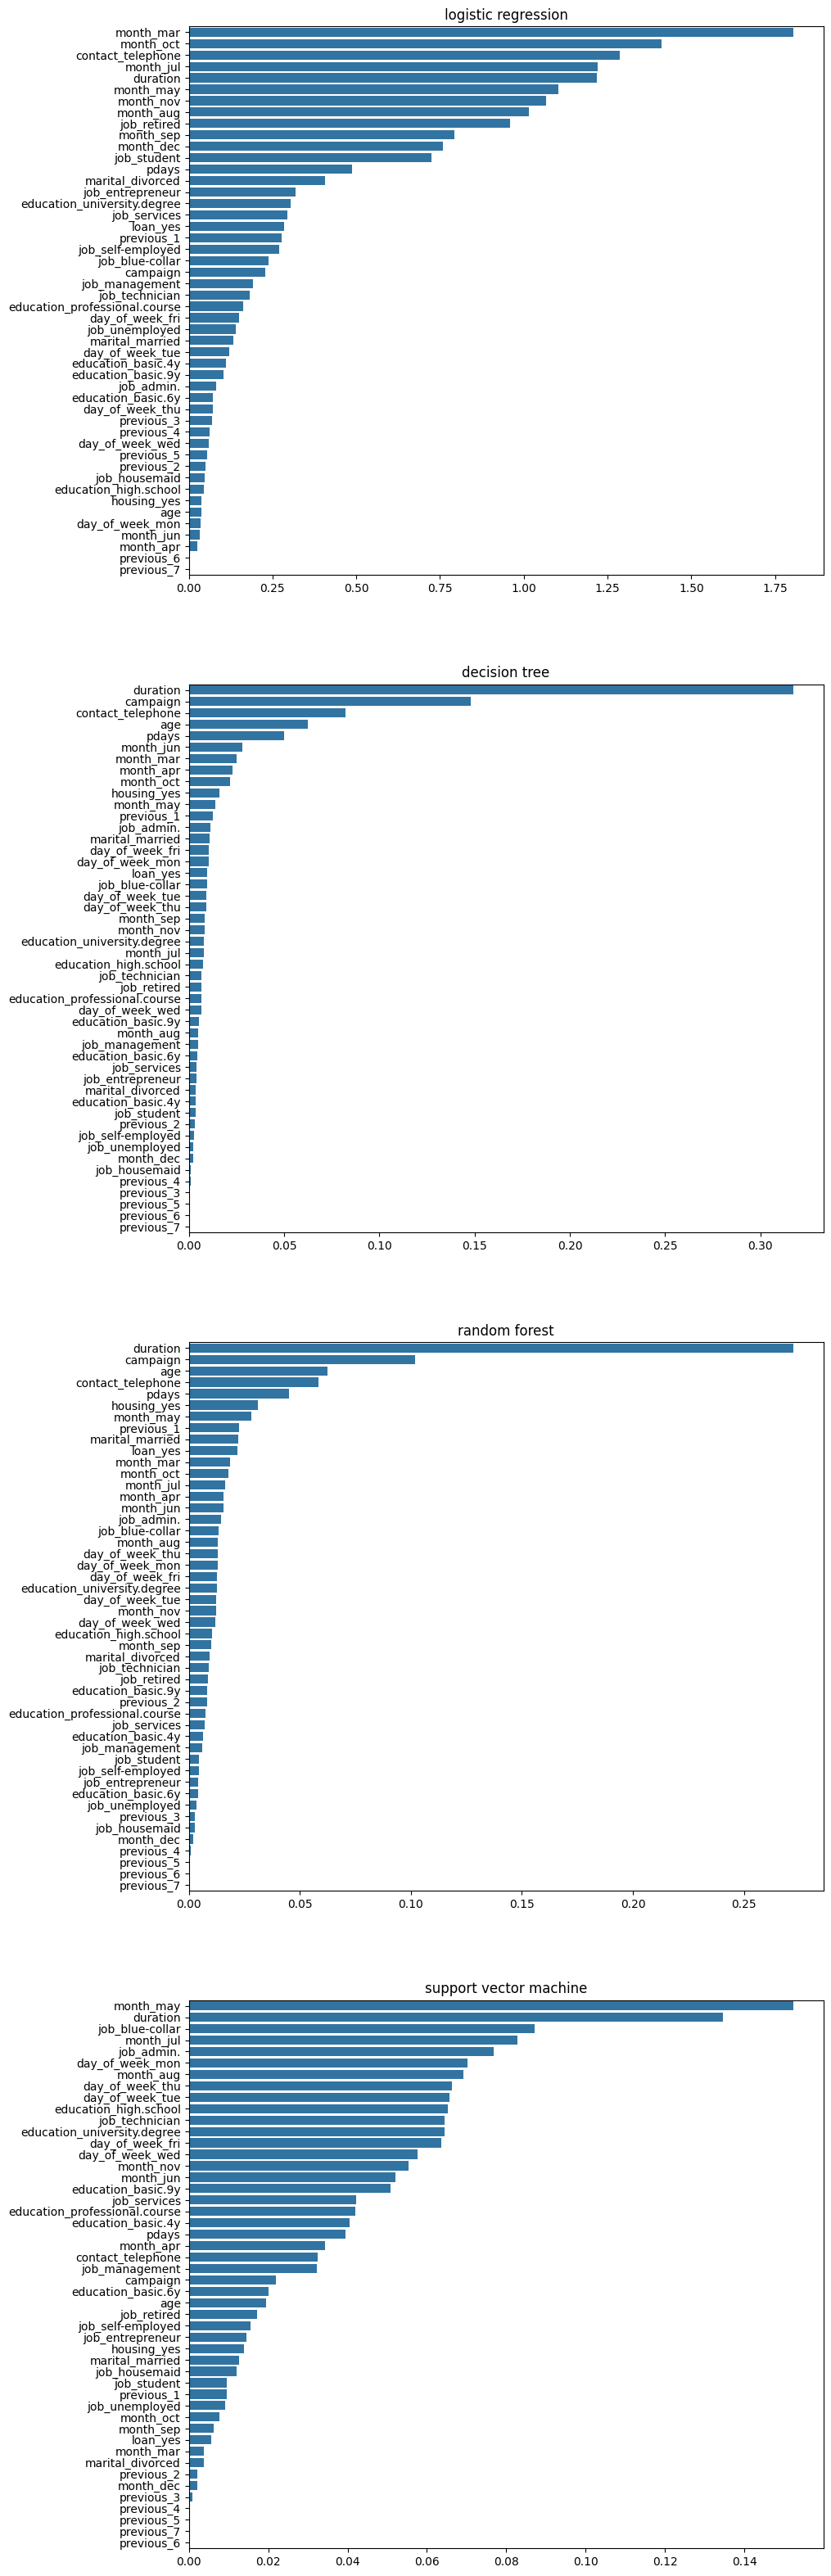

In [11]:
feature_importance_list = [trained_models[trained_models_str.index("logistic_regression_model")].coef_[0],
                           trained_models[trained_models_str.index("decision_tree_model")].feature_importances_,
                           trained_models[trained_models_str.index("random_forest_model")].feature_importances_,
                            permutation_importance(trained_models[trained_models_str.index("svc_model")],X_test,y_test,n_repeats=10,random_state=42).importances_mean
                            ]

model_name_list=["logistic regression", "decision tree","random forest", "support vector machine"]

feature_importance_subplots(feature_importance_list,model_name_list,X_test.columns)